In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
from utils import sampling
import matplotlib.pyplot as plt
from time import time

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Get data and preprocess
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train)), np.prod(x_train.shape[1:]))

In [4]:
#%%
# Implementacija enkoderja:
original_dim = np.prod(x_train.shape[1:]) # dimenzija vhodnih podatkov
hidden_dim = 64 # skriti sloj z 64 node -i
latent_dim = 2 # 2D latentni prostor

In [5]:

# Input layer
inputs = keras.Input(shape=(original_dim ,) )
# First hidden layer
h = keras.layers.Dense(hidden_dim, activation ='selu')(inputs)

z_mean = keras.layers.Dense(latent_dim)(h)
z_log_var = keras.layers.Dense(latent_dim)(h)

# Layer that calculates value z = z_mean + z_var * epsilon
z = keras.layers.Lambda(sampling)([z_mean, z_log_var])

#Define model for encoder:
# encoder returns z_mean, z_log_var, z
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
# %%
# Implementation of decoder
latent_inputs = keras.Input(shape=(latent_dim, ), name='z_sampling')
# hidden layer x
x = keras.layers.Dense(hidden_dim, activation='selu')(latent_inputs)
outputs = keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [6]:
# Define VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae')

rec_loss = keras.losses.binary_crossentropy(inputs, outputs)
rec_loss *= original_dim
kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")


In [57]:
# Train model on train data
batch_size = 1024*16
start = time()
history = vae.fit(x_train, x_train, epochs=1000, batch_size=batch_size, validation_data=None)
print("Elapsed time = %.0fs" %(time()-start))

Epoch 1/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5325
Epoch 2/1000
4/4 [==============================] - 0s 21ms/step - loss: 151.6284
Epoch 3/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5375
Epoch 4/1000
4/4 [==============================] - 0s 19ms/step - loss: 151.5272
Epoch 5/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.6725
Epoch 6/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5887
Epoch 7/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.6391
Epoch 8/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.6065
Epoch 9/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5684
Epoch 10/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5347
Epoch 11/1000
4/4 [==============================] - 0s 20ms/step - loss: 151.5085
Epoch 12/1000
4/4 [==============================] - 0s 18ms/step - loss: 151.6245
Epoch 13/1000

In [58]:
x_encoded = encoder.predict(x_train)[2]

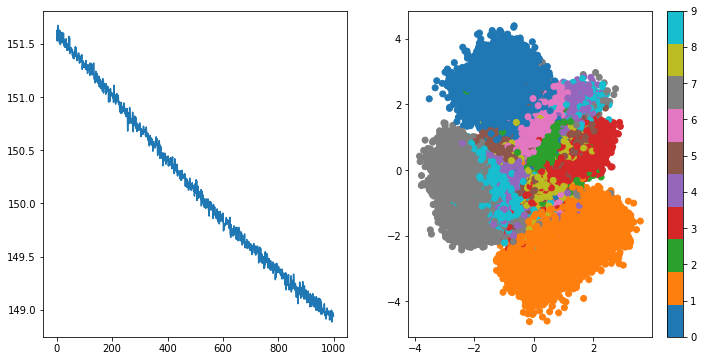

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(history.history['loss'])

cm = plt.cm.get_cmap('tab10')
sc = ax[1].scatter(x_encoded[:,0], x_encoded[:, 1], c=y_train, cmap=cm)
plt.colorbar(sc)

In [35]:
import numpy as np

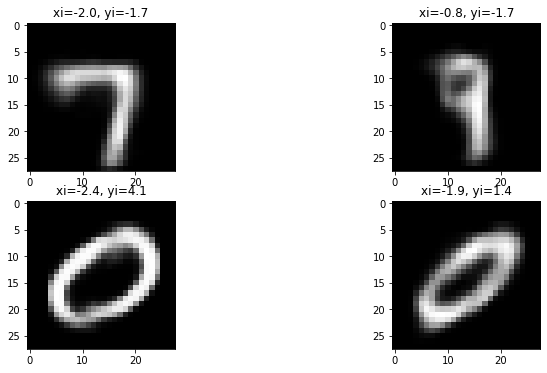

In [62]:

fig, ax = plt.subplots(2,2, figsize=(12,6))

ax = ax.flatten()
cm = plt.cm.get_cmap('gray')
for i in range(4):
    [xi, yi] = [np.random.normal(0, 2),np.random.normal(0, 2)]
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    img = x_decoded.reshape(28, 28)
    naslov = "xi=%0.1f, yi=%0.1f" %(xi, yi)
    ax[i].set_title(naslov)
    ax[i].imshow(img, cmap=cm)
